In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTMCell, LSTM
from tensorflow.keras.models import load_model
from tensorflow import function

In [3]:

def download_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

def create_dataset(data):
    data = data.filter(['Adj Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset, training_data_len

def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def create_training_data(scaled_data, training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    return np.array(x_train), np.array(y_train)

def reshape_data(x_train):
    return np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def build_and_train_model(x_train, y_train):
    model = Sequential()
    # model.add(RNN(LSTMCell(128), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # model.add(RNN(LSTMCell(64), return_sequences=False))
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=2)
    return model

def create_test_data(scaled_data, dataset, training_data_len):
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    return np.array(x_test), y_test

def make_predictions(model, x_test, scaler):
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def calculate_rmse(predictions, y_test):
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))

def plot_data(data, training_data_len, predictions, symbol):
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid.loc[:, 'Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title(symbol + ' Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price SGD ($)', fontsize=18)
    plt.plot(train['Adj Close'])
    plt.plot(valid[['Adj Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

def save_model(model, model_path):
    model.save(model_path)

def load_model_if_exists(model_path):
    if os.path.exists(model_path):
        return load_model(model_path)
    else:
        return None

[*********************100%%**********************]  1 of 1 completed
Epoch 1/2


2023-12-23 10:51:41.639606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-23 10:51:41.811259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-23 10:51:41.851951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-23 10:51:41.928428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-23 10:51:42.036060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5654/5654 [==============================] - 85s 15ms/step - loss: 6.0042e-04
Epoch 2/2
5654/5654 [==============================] - 84s 15ms/step - loss: 2.0387e-04


/Users/darrels/miniforge3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 1/10 [==>...........................] - ETA: 2s

2023-12-23 10:54:29.629745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-23 10:54:29.698823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-23 10:54:29.742389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 10ms/step


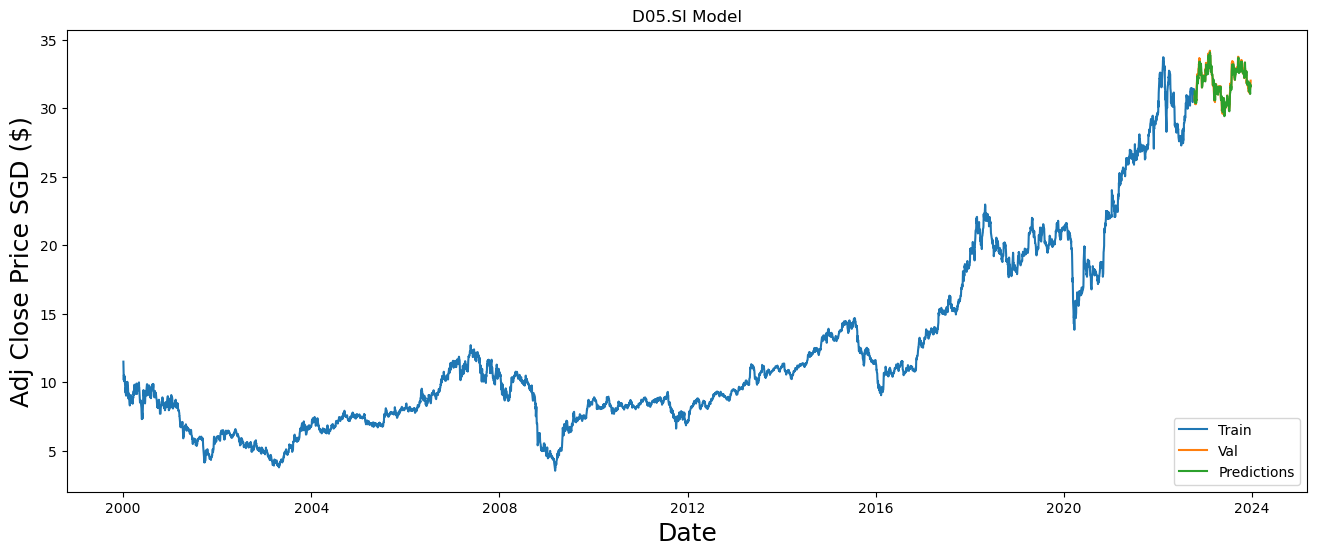

In [8]:
def main():
    symbol = "D05.SI"
    model_path = f"models/{symbol}_model.h5"
    
    data = download_data(symbol, '2000-01-01', datetime.now())
    dataset, training_data_len = create_dataset(data)
    scaled_data, scaler = scale_data(dataset)
    
    model = load_model_if_exists(model_path)

    if model is None:
        x_train, y_train = create_training_data(scaled_data, training_data_len)
        x_train = reshape_data(x_train)
        model = build_and_train_model(x_train, y_train)
        save_model(model, model_path)

    
    x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
    predictions = make_predictions(model, x_test, scaler)
    # rmse = calculate_rmse(predictions, y_test)
    # print(f'RMSE: {rmse}')
    plot_data(data, training_data_len, predictions, symbol)

if __name__ == "__main__":
    main()